In [ ]:
pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 31.1 MB/s 


In [ ]:
# example of loading the keras facenet model
from keras.models import load_model
# load the model
model = load_model('/content/drive/MyDrive/Face_recognition/facenet_keras.h5')
# summarize input and output shape
print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


In [ ]:
from os import listdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN
 
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	if results:
	  # extract the bounding box from the first face
	  x1, y1, width, height = results[0]['box']
	  # bug fix
	  x1, y1 = abs(x1), abs(y1)
	  x2, y2 = x1 + width, y1 + height
	  # extract the face
	  face = pixels[y1:y2, x1:x2]
	  # resize pixels to the model size
	  image = Image.fromarray(face)
	  image = image.resize(required_size)
	  face_array = asarray(image)
	  return face_array
 

In [ ]:
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces

In [ ]:
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not os.path.isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

In [ ]:
import os
import shutil
import glob
def PrepareDataset(Dataset_path , classes):
  for cl in classes:
    images_path = os.path.join(Dataset_path, cl)
    Images = glob.glob(images_path + '/*.*')

    train_images ,validation_images, test_images = Images[:round(0.8*len(Images))] , Images[round(0.8*len(Images)):round(0.9*len(Images))],Images[round(0.9*len(Images)):]
    
    for train in train_images:
      if not os.path.exists(os.path.join(Dataset_path , 'Train' , cl)):
        os.makedirs(os.path.join(Dataset_path , 'Train', cl))
      shutil.move(train , os.path.join(Dataset_path , 'Train' , cl))
    
    for test in test_images:
      if not os.path.exists(os.path.join(Dataset_path , 'Test' , cl)):
        os.makedirs(os.path.join(Dataset_path , 'Test' , cl))
      shutil.move(test , os.path.join(Dataset_path , 'Test'  , cl))
    
    for val in validation_images:
      if not os.path.exists(os.path.join(Dataset_path , 'Val' , cl)):
        os.makedirs(os.path.join(Dataset_path , 'Val' , cl))
      shutil.move(val , os.path.join(Dataset_path , 'Val'  , cl))

In [ ]:
PrepareDataset(Dataset_Path , Classes)

In [ ]:
Dataset_Path = "/content/drive/MyDrive/Face_recognition/DataSet_Images"
Classes = listdir(Dataset_Path)
Classes

['Train', 'Test', 'Val']

In [ ]:
# load train dataset
trainX, trainy = load_dataset('/content/drive/MyDrive/Face_recognition/DataSet_Images/Train/')
print(trainX.shape, trainy.shape)
# load validation dataset
valX, valy = load_dataset('/content/drive/MyDrive/Face_recognition/DataSet_Images/Val/')
print(valX.shape, valy.shape)
# load test dataset
testX, testy = load_dataset('/content/drive/MyDrive/Face_recognition/DataSet_Images/Test/')
print(testX.shape, testy.shape)
# save arrays to one file in compressed format

>loaded 101 examples for class: Ibrahim Saber
>loaded 84 examples for class: Ahmed Mahmoud
>loaded 90 examples for class: Ahmed nasser ahmed
>loaded 80 examples for class: Khloud Khaled
>loaded 106 examples for class: Radwa Refat
>loaded 131 examples for class: Taqwa Hamed
>loaded 85 examples for class: Yasmeen Mohamed
(677,) (677,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


>loaded 12 examples for class: Ibrahim Saber
>loaded 10 examples for class: Ahmed Mahmoud
>loaded 12 examples for class: Ahmed nasser ahmed
>loaded 10 examples for class: Khloud Khaled
>loaded 14 examples for class: Radwa Refat
>loaded 17 examples for class: Taqwa Hamed
>loaded 10 examples for class: Yasmeen Mohamed
(85,) (85,)
>loaded 13 examples for class: Ibrahim Saber
>loaded 11 examples for class: Ahmed Mahmoud
>loaded 11 examples for class: Ahmed nasser ahmed
>loaded 10 examples for class: Khloud Khaled
>loaded 13 examples for class: Radwa Refat
>loaded 16 examples for class: Taqwa Hamed
>loaded 11 examples for class: Yasmeen Mohamed
(85,) (85,)


NameError: ignored

In [ ]:
from numpy import savez_compressed

In [ ]:
savez_compressed('/content/drive/MyDrive/Face_recognition/Dataset.npz', trainX, trainy,valX ,valy, testX, testy)

In [ ]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model
import numpy as np
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = np.float32(face_pixels)
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]
 

In [ ]:
# load the face dataset
data = load('/content/drive/MyDrive/Face_recognition/Dataset.npz' , allow_pickle=True)
trainX, trainy, valX, valy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3'] ,  data['arr_4'] , data['arr_5']
print('Loaded: ', trainX.shape, trainy.shape,valX.shape, valy.shape, testX.shape, testy.shape)
# load the facenet 
model = load_model('/content/drive/MyDrive/Face_recognition/facenet_keras.h5')
# model = load_model('facenet_keras.h5')
print('Loaded Model')

Loaded:  (613,) (613,) (77,) (77,) (77,) (77,)
Loaded Model


In [ ]:
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# convert each face in the test set to an embedding
newValX = list()
for face_pixels in valX:
	embedding = get_embedding(model, face_pixels)
	newValX.append(embedding)
newValX = asarray(newValX)
print(newValX.shape)
# save arrays to one file in compressed format
savez_compressed('/content/drive/MyDrive/Face_recognition/Dataset-faces-embeddings.npz', newTrainX, trainy,newValX, valy, newTestX, testy)

(613, 128)
(77, 128)
(77, 128)


In [ ]:
# develop a classifier for the Faces Dataset
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
import pickle

# load dataset
data = load('/content/drive/MyDrive/Face_recognition/Dataset-faces-embeddings.npz', allow_pickle=True)
trainX, trainy, valX, valy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3'] ,  data['arr_4'] , data['arr_5']
print('Dataset: train=%d, val=%d, test=%d' % (trainX.shape[0],valX.shape[0],testX.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
valX = in_encoder.transform(valX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
valy = out_encoder.transform(valy)
# fit model
model = SVC(kernel='linear', probability=True , verbose=1, max_iter=1000)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
yhat_val = model.predict(valX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
score_val = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f,val=%.3f, test=%.3f' % (score_train*100,score_val*100, score_test*100))

# save the model to disk
filename = '/content/drive/MyDrive/Face_recognition/finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

Dataset: train=613, val=77, test=77
[LibSVM]Accuracy: train=98.206,val=92.208, test=92.208


Predicted: Ibrahim Saber (96.115)
Expected: Ibrahim Saber


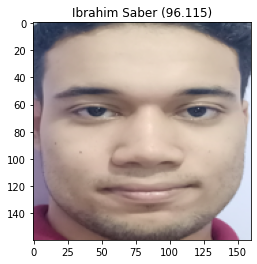

In [ ]:
# develop a classifier for the  Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load faces
data = load('/content/drive/MyDrive/Face_recognition/Dataset.npz' , allow_pickle=True)
trainX, trainy, valX, valy, testX_faces, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3'] ,  data['arr_4'] , data['arr_5']
# load face embeddings
data = load('/content/drive/MyDrive/Face_recognition/Dataset-faces-embeddings.npz', allow_pickle=True)
trainX, trainy, valX, valy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3'] ,  data['arr_4'] , data['arr_5']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

In [ ]:
testX.shape

(77, 128)

In [ ]:
data = load('/content/drive/MyDrive/Face_recognition/Dataset.npz' , allow_pickle=True)
trainX, trainy, valX, valy, testX_faces, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3'] ,  data['arr_4'] , data['arr_5']


In [ ]:
trainX[0].shape

(160, 160, 3)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2 , VGG16 
from keras.models import Sequential , Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input
from keras.layers import Conv2D , MaxPooling2D , Dense , Flatten , Activation , Dropout
from tensorflow.keras.optimizers import Adam , RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img , img_to_array 
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from IPython.display import Image
import cv2
import os
from sklearn.preprocessing import LabelBinarizer

In [ ]:
train_Images = []
for img in trainX:
  resized = cv2.resize(img , (224,224) ,  interpolation = cv2.INTER_AREA)
  train_Images.append(resized)

train_Images = np.array(train_Images)
train_Images = cv2.normalize(train_Images ,None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) #Normalizing the image data
train_Images.shape

(613, 224, 224, 3)

In [ ]:
data = load('/content/drive/MyDrive/Face_recognition/Dataset-faces-embeddings.npz' , allow_pickle=True)
trainX, trainy, valX, valy, testX_faces, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3'] ,  data['arr_4'] , data['arr_5']

In [ ]:
LB = LabelBinarizer()
Labels = LB.fit_transform(trainy) # creating an object
Labels = np.array(Labels) # converting the labels into a batch
Labels.shape

(613, 7)

In [ ]:
val_Images = []
for img in valX:
  resized = cv2.resize(img , (224,224) ,  interpolation = cv2.INTER_AREA)
  val_Images.append(resized)
val_Images = np.array(val_Images)
val_Images = cv2.normalize(val_Images ,None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) #Normalizing the image data
val_Images.shape

(77, 224, 224, 3)

In [ ]:
val_Labels = LB.fit_transform(valy) # creating an object
val_Labels = np.array(val_Labels) # converting the labels into a batch
val_Labels.shape

(77, 7)

In [ ]:
trainX

array([[ 0.44866467, -0.239526  , -0.7831485 , ...,  0.6522707 ,
         0.9603629 ,  0.16758327],
       [ 0.44084105, -0.06667213, -0.7962409 , ...,  0.7275478 ,
         0.86443156,  0.06629559],
       [ 0.47286752, -0.7082337 , -0.7624354 , ...,  1.0665509 ,
         1.221362  , -0.17545006],
       ...,
       [-0.1370826 ,  0.01524591,  0.89489144, ...,  1.883133  ,
         1.0477874 ,  1.6479204 ],
       [ 0.47633246,  0.97883797,  0.14272799, ...,  2.0103202 ,
         0.61040723,  0.90387625],
       [ 0.19769898,  1.3025551 , -0.2123025 , ...,  2.6571672 ,
         1.9450299 ,  0.82099986]], dtype=float32)

In [ ]:
trainy[0]

'Ibrahim Saber'

In [ ]:
LB = LabelBinarizer()
testLabels = LB.fit_transform(testy) # creating an object
testLabels = np.array(testLabels) # converting the labels into a batch
testLabels.shape

(77, 7)

In [ ]:
cnn_model= Sequential([
    Flatten(input_shape = (128,)),
    Dense(2048, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    #7 is the number of outputs
    Dense(7, activation='softmax')  
])

cnn_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),#'categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [ ]:
DataAugmentaion = ImageDataGenerator(
                                  rotation_range=25,
                                  zoom_range=0.35,
                                  horizontal_flip=True,
                                  shear_range = 0.2
                                  )

In [ ]:
history=cnn_model.fit(
    trainX, Labels , batch_size=1,
    epochs=50,
    validation_data=( valX , val_Labels)
)

Epoch 1/50
613/613 [==============================] - 5s 3ms/step - loss: 1.0539 - accuracy: 0.6966 - val_loss: 0.0860 - val_accuracy: 0.9870
Epoch 2/50
613/613 [==============================] - 2s 3ms/step - loss: 0.1133 - accuracy: 0.9706 - val_loss: 0.1433 - val_accuracy: 0.9870
Epoch 3/50
613/613 [==============================] - 2s 3ms/step - loss: 0.0574 - accuracy: 0.9804 - val_loss: 0.1673 - val_accuracy: 0.9870
Epoch 4/50
613/613 [==============================] - 2s 3ms/step - loss: 0.0582 - accuracy: 0.9804 - val_loss: 0.2073 - val_accuracy: 0.9870
Epoch 5/50
613/613 [==============================] - 2s 3ms/step - loss: 0.0372 - accuracy: 0.9902 - val_loss: 0.3625 - val_accuracy: 0.9870
Epoch 6/50
613/613 [==============================] - 2s 3ms/step - loss: 0.0351 - accuracy: 0.9821 - val_loss: 3.9821e-05 - val_accuracy: 1.0000
Epoch 7/50
613/613 [==============================] - 2s 3ms/step - loss: 0.0250 - accuracy: 0.9918 - val_loss: 0.0578 - val_accuracy: 0.9870
Ep

In [ ]:
cnn_model.save("/content/drive/MyDrive/Face_recognition/Classification.hdf5")

In [ ]:
# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load faces
data = load('/content/drive/MyDrive/Face_recognition/Dataset.npz' , allow_pickle=True)
trainX, trainy, valX, valy, testX_faces, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3'] ,  data['arr_4'] , data['arr_5']
# load face embeddings
data = load('/content/drive/MyDrive/Face_recognition/Dataset-faces-embeddings.npz', allow_pickle=True)
trainX, trainy, valX, valy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3'] ,  data['arr_4'] , data['arr_5']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)


# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat = cnn_model.predict(samples)
# get name
class_index = np.argmax(yhat)
class_probability = yhat[0][np.argmax(yhat)] * 100
predict_names = out_encoder.inverse_transform(np.array([class_index]))
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

NameError: ignored

In [ ]:
cnn_model.evaluate(testX, testLabels)

3/3 [==============================] - 0s 6ms/step - loss: 0.2783 - accuracy: 0.9351


[0.2783127427101135, 0.9350649118423462]

In [ ]:
# load faces
data = load('/content/drive/MyDrive/Face_recognition/Dataset.npz' , allow_pickle=True)
trainX, trainy, valX, valy, testX_faces, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3'] ,  data['arr_4'] , data['arr_5']
# load face embeddings
data = load('/content/drive/MyDrive/Face_recognition/Dataset-faces-embeddings.npz', allow_pickle=True)
trainX, trainy, valX, valy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3'] ,  data['arr_4'] , data['arr_5']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

yhat = cnn_model.predict(testX , batch_size = 32)


In [ ]:
yhat

array([[1.25816455e-02, 6.61370158e-03, 9.26011264e-01, 1.69769898e-02,
        2.05368940e-02, 3.48818186e-03, 1.37913302e-02],
       [1.00834798e-02, 6.60264539e-03, 9.36342716e-01, 1.63435359e-02,
        1.44274188e-02, 3.18515906e-03, 1.30151007e-02],
       [1.36745404e-02, 5.70210675e-03, 9.30208921e-01, 1.38359098e-02,
        1.99963115e-02, 3.30555160e-03, 1.32767186e-02],
       [1.44276880e-02, 4.88630030e-03, 9.21429217e-01, 2.01155636e-02,
        1.75986681e-02, 3.70651856e-03, 1.78360511e-02],
       [1.90133508e-02, 5.66225313e-03, 9.31302547e-01, 1.29473405e-02,
        1.41076352e-02, 4.23464691e-03, 1.27321947e-02],
       [2.39358693e-02, 5.43092331e-03, 9.27252054e-01, 1.24088312e-02,
        1.49919419e-02, 4.64229053e-03, 1.13381334e-02],
       [1.95390470e-02, 6.27311785e-03, 9.29704428e-01, 1.29777463e-02,
        1.49104223e-02, 4.53364942e-03, 1.20615354e-02],
       [9.35405772e-03, 6.23969687e-03, 9.38528776e-01, 1.68006606e-02,
        1.32421246e-02, 2

In [ ]:
yhat = cnn_model.predict(testX , batch_size = 32)

In [ ]:
np.argmax(yhat[0])

2

In [ ]:
for pred in zip(yhat):
  print(np.argmax(pred)) , print(pred[np.argmax(pred)])
  

NameError: ignored